# Testing MCMC on Pastas Models
*R.A. Collenteur, University of Graz, November 2019*

In this notebook it is shown how the MCMC-algorithm can be used to estimate the model parameters for a Pastas model. Besides Pastas the following Python Packages have to be installed to run this notebook:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [lmfit](https://lmfit.github.io/lmfit-py/)
- [corner](https://corner.readthedocs.io)

In [1]:
import numpy as np
import pandas as pd

import pastas as ps
import corner
import emcee as mc

import matplotlib.pyplot as plt

ps.set_log_level("ERROR")

## 1. Create a Pastas Model
The first step is to create a Pastas Model object, including the RechargeModel to simulate the effect of precipitation and evaporation on the groundwater heads.

Fit report head                     Fit Statistics
nfev    19                     EVP           92.91
nobs    644                    R2             0.93
noise   True                   RMSE           0.11
tmin    1985-11-14 00:00:00    AIC        -3257.53
tmax    2015-06-28 00:00:00    BIC        -3235.20
freq    D                      Obj            2.02
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   686.246855   ±5.30%  215.674528  True
recharge_a   159.386067   ±5.01%   10.000000  True
recharge_f    -1.305358   ±4.04%   -1.000000  True
constant_d    27.920133   ±0.21%   27.900078  True
noise_alpha   49.911858  ±11.86%   15.000000  True


<AxesSubplot:title={'center':'Results of head'}, ylabel='Groundwater levels [meter]'>

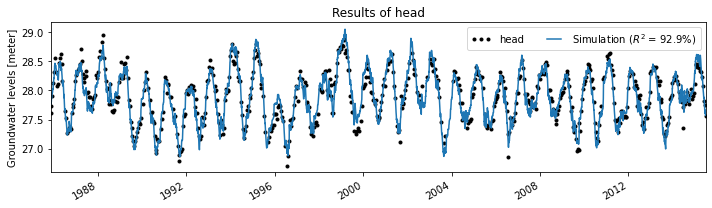

In [2]:
# read observations and create the time series model
obs = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
rain = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

# Create the time series model
ml = ps.Model(obs, name="head")

sm = ps.RechargeModel(prec=rain, evap=evap, rfunc=ps.Exponential, name='recharge')
ml.add_stressmodel(sm)
ml.solve(noise=True, report="basic")

ml.plot(figsize=(10,3))

## 2. Use the EMCEE Hammer
Apart from the default solver (ps.LeastSquares), Pastas also contains the option to use the LmFit package to estimate the parameters. This package wraps multiple optimization techniques, one of which is [Emcee](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee). The code bock below shows how to use this method to estimate the parameters of Pastas models.

Emcee takes a number of keyword arguments that determine how the optimization is done. The most important is the `steps` argument, that determines how many steps each of the walkers takes. The argument `nwalkers` can be used to set the number of walkers (default is 100). The `burn` argument determines how many samples from the start of the walkers are removed. The argument `thin` finally determines how many samples are accepted (1 in thin samples).

In [3]:
ml.set_parameter("noise_alpha", vary=True)
#ml.set_parameter("constant_d", vary=False)
ml.solve(tmin="2002", noise=True, initial=False, fit_constant=False, solver=ps.LmfitSolve, 
         method="emcee", steps=200, burn=10, thin=5, is_weighted=True, nan_policy="omit");

100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.61it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [21.13363128 22.66958084 15.53449903 23.78152128]
Fit report head                        Fit Statistics
nfev    20000                  EVP           85.16
nobs    287                    R2             0.85
noise   True                   RMSE           0.15
tmin    2002-01-01 00:00:00    AIC        -1413.21
tmax    2015-06-28 00:00:00    BIC        -1398.57
freq    D                      Obj            2.03
warmup  3650 days 00:00:00     ___                
solver  LmfitSolve             Interp.          No

Parameters (4 optimized)
                 optimal    stderr     initial   vary
recharge_A   1230.639764  ±109.36%  686.246855   True
recharge_a    368.852658   ±89.35%  159.386067   True
recharge_f     -1.196124   ±48.19%   -1.305358   True
constant_d     27.746679     ±nan%    0.000000  False
noise_alpha   172.259773  ±240.

## 3. Visualize the results
The results are stored in the `result` object, accessible through `ml.fit.result`. The object `ml.fit.result.flatchain` contains a Pandas DataFrame with $n$ the parameter samples, whgere $n$ is calculated as follows:

$n = \frac{(\text{steps}-\text{burn})\cdot\text{nwalkers}}{\text{thin}} $

## Corner.py
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

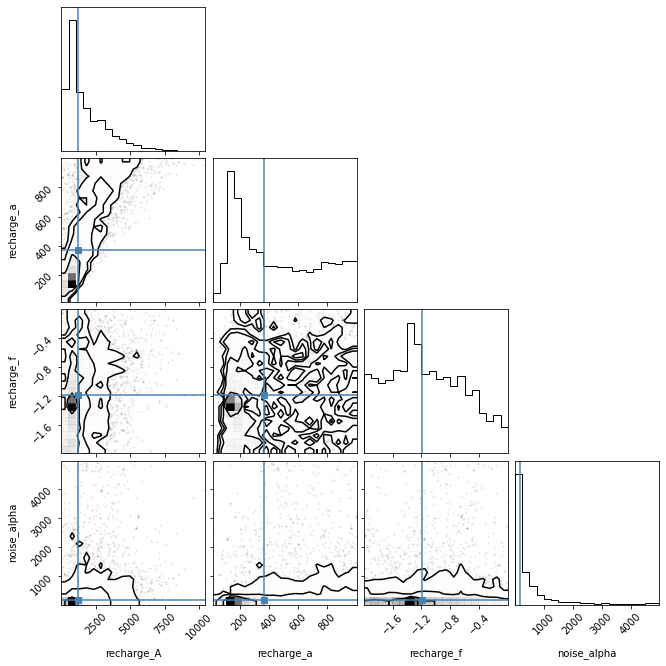

In [4]:
corner.corner(ml.fit.result.flatchain, truths=list(ml.parameters[ml.parameters.vary == True].optimal));

## 4. What happens to the walkers at each step?
The walkers take steps in different directions for each step. It is expected that after a number of steps, the direction of the step becomes random, as a sign that an optimum has been found. This can be checked by looking at the autocorrelation, which should be insignificant after a number of steps (NOT SURE HOW TO INTERPRET THIS YET). However it does not seem the case that the parameters converge to come optimum yet, even for the simple Linear model.

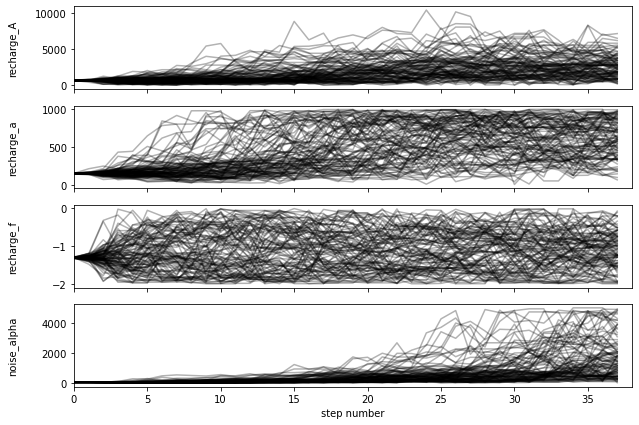

In [6]:
labels = ml.fit.result.flatchain.columns

fig, axes = plt.subplots(labels.size, figsize=(10, 7), sharex=True)
samples = ml.fit.result.chain
for i in range(labels.size):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

## 5. Plot some simulated time series to display uncertainty?

(27.0, 30.0)

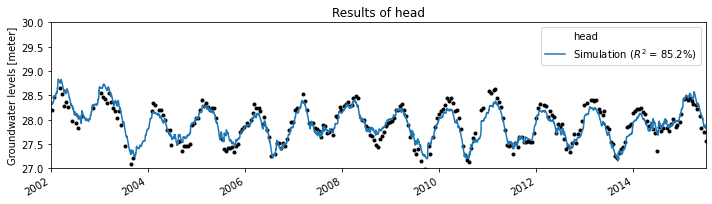

In [7]:
ax = ml.plot(figsize=(10,3))

inds = np.random.randint(len(ml.fit.result.flatchain), size=100)
for ind in inds:
    params = ml.fit.result.flatchain.iloc[ind].values
    ml.simulate(params).plot(c="k", alpha=0.1)
plt.ylim(27,30)